### Importing Libraries

In [106]:
import sys
sys.path.append('../src')

from data_management import load_data, preprocess_data, train_data_split, undo_scaling
from model_training import define_model_lstm, train_model, define_model_gru, set_random_seed
from model_evaluation import score_model, grid_search, pred_test, actual_predict_plot, war_no_war_plot, plot_failure_analysis, plot_actual_war_test

import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [54]:
n_future = 1
n_past = 20  
economic_war_data = load_data('../data/war_final.csv')
economic_data_scaled, economic_data_scaler = preprocess_data(economic_war_data)

### Best Performing Model(GRU) Training

In [42]:
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
window=20
features=X_train.shape[2]
model_gru=define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, window=window, features=features)
trained_model_gru = train_model(model_gru, X_train, y_train, n_batch, epochs=100, is_early_stopping=True)

train_size =  257
test_size =  29
train_size =  (257, 20, 12)
test_size =  (29, 20, 12)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 24)                2736      
                                                                 
 dropout_16 (Dropout)        (None, 24)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,761
Trainable params: 2,761
Non-trainable params: 0
_________________________________________________________________
X_train (257, 20, 12)
y_train (257, 1)
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping


In [3]:
gru_train_df = pd.DataFrame({
    'GRU_TRAIN_MSE': trained_model_gru.history['loss'],
    'GRU_TRAIN_RMSE': trained_model_gru.history['root_mean_squared_error']
})

gru_val_df = pd.DataFrame({
    'GRU_VAL_MSE': trained_model_gru.history['val_loss'],
    'GRU_VAL_RMSE': trained_model_gru.history['val_root_mean_squared_error']
})
concatenated_df_gru = pd.concat([gru_train_df, gru_val_df], axis=1)
concatenated_df_gru['epoch'] = range(0, len(concatenated_df_gru))
concatenated_df_gru.head(5)

,GRU_TRAIN_MSE,GRU_TRAIN_RMSE,GRU_VAL_MSE,GRU_VAL_RMSE,epoch
0,0.126006,0.354973,0.040298,0.200743,0
1,0.032716,0.180874,0.003759,0.061310,1
2,0.026761,0.163588,0.004018,0.063390,2
3,0.023119,0.152050,0.005063,0.071152,3
4,0.018524,0.136102,0.004624,0.067997,4


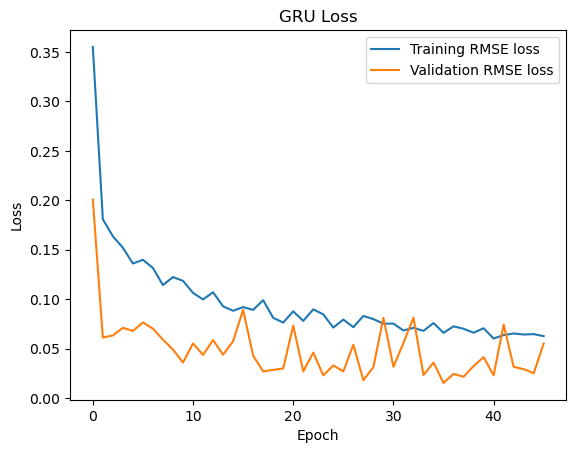

In [4]:
import matplotlib.pyplot as plt
plt.plot(concatenated_df_gru['epoch'], concatenated_df_gru['GRU_TRAIN_RMSE'], label='Training RMSE loss')
plt.plot(concatenated_df_gru['epoch'], concatenated_df_gru['GRU_VAL_RMSE'], label='Validation RMSE loss')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc='upper right')
plt.show()

### Prediction On Test Data for best performing model in terms of RMSE score

In [5]:
test_results_without_war_df, rmse_without_war=pred_test(trained_model_gru.model,X_test,y_test)
test_results_without_war_df.head()

1/1 [==============================] - 0s 159ms/step


,Predictions,Actuals
0,1.603251,1.620114
1,1.595936,1.645196
2,1.600206,1.672469
3,1.617336,1.698906
4,1.631170,1.720886


In [6]:
rmse_without_war

0.39589029478635335

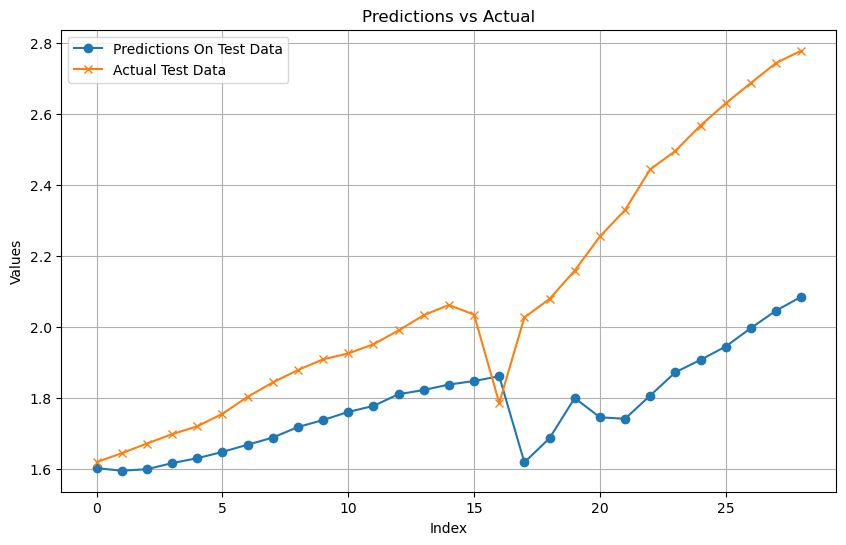

In [7]:
actual_predict_plot(test_results_without_war_df)

In [37]:
def add_war_variable_to_df(df):
    war_periods = {
        "Korean War": ("1950-06-25", "1953-07-27"),
        "Vietnam War": ("1965-03-08", "1975-04-30"),
        "Persian Gulf War": ("1990-08-02", "1991-02-28"),
        "War in Afghanistan": ("2001-10-07", "2021-08-30"),
        "Iraq War": ("2003-03-20", "2011-12-18"),
        "Russia Ukraine War": ("2022-02-24", "2023-09-30")  # Assuming "till now" is April 2023
    }

    df['war'] = 0

    for start, end in war_periods.values():
        df.loc[df.index.to_series().between(start, end), 'war'] = 1
    
    return df

### New model with War as a proxy variable

In [38]:
economic_data_scaled_with_war = add_war_variable_to_df(economic_data_scaled)

param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
window = 20
n_future = 1
n_past = window  
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled_with_war, n_future, n_past)
features = X_train.shape[2]
num_nodes=param_grid['num_nodes']
learning_rate=param_grid['learning_rate']
drop_out=param_grid['drop_out']
init_mode=param_grid['init_mode']
activation=param_grid['activation']
optimizer=param_grid['optimizer']
n_batch=param_grid['batch_size']
model_gru=define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, features=features, window=window)
trained_model_gru_with_war = train_model(model_gru, X_train, y_train, n_batch, epochs=100, is_early_stopping=True)
test_results_with_war_df, rmse_with_war=pred_test(trained_model_gru_with_war.model,X_test,y_test)

train_size =  257
test_size =  29
train_size =  (257, 20, 13)
test_size =  (29, 20, 13)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 24)                2808      
                                                                 
 dropout_15 (Dropout)        (None, 24)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,833
Trainable params: 2,833
Non-trainable params: 0
_________________________________________________________________
X_train (257, 20, 13)
y_train (257, 1)
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
1/1 [==============================] - 0s 140ms/step


In [9]:
gru_war_train_df = pd.DataFrame({
    'GRU_TRAIN_MSE_WAR': trained_model_gru_with_war.history['loss'],
    'GRU_TRAIN_RMSE_WAR': trained_model_gru_with_war.history['root_mean_squared_error']
})

gru_war_val_df = pd.DataFrame({
    'GRU_VAL_MSE_WAR': trained_model_gru_with_war.history['val_loss'],
    'GRU_VAL_RMSE_WAR': trained_model_gru_with_war.history['val_root_mean_squared_error']
})
concatenated_df_gru_war = pd.concat([gru_war_train_df, gru_war_val_df], axis=1)
concatenated_df_gru_war['epoch'] = range(0, len(concatenated_df_gru_war))

In [10]:
test_results_with_war_df.head()

,Predictions,Actuals
0,1.600685,1.620114
1,1.596937,1.645196
2,1.602877,1.672469
3,1.618722,1.698906
4,1.630770,1.720886


### Model prediction with forcing war variable to '0' and '1'

In [11]:
economic_data_scaled['war'] = 0
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)
test_results_forced_no_war_df, rmse_forced_no_war = pred_test(trained_model_gru_with_war.model, X_test, y_test)

economic_data_scaled['war'] = 1
(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled, n_future, n_past)

test_results_forced_always_war_df, rmse_forced_always_war=pred_test(trained_model_gru_with_war.model,X_test,y_test)

train_size =  257
test_size =  29
train_size =  (257, 20, 13)
test_size =  (29, 20, 13)
1/1 [==============================] - 0s 11ms/step
train_size =  257
test_size =  29
train_size =  (257, 20, 13)
test_size =  (29, 20, 13)
1/1 [==============================] - 0s 11ms/step


In [ ]:
test_results_forced_always_war_df=undo_scaling(test_results_forced_always_war_df, economic_data_scaler)
test_results_forced_no_war_df=undo_scaling(test_results_forced_no_war_df, economic_data_scaler)

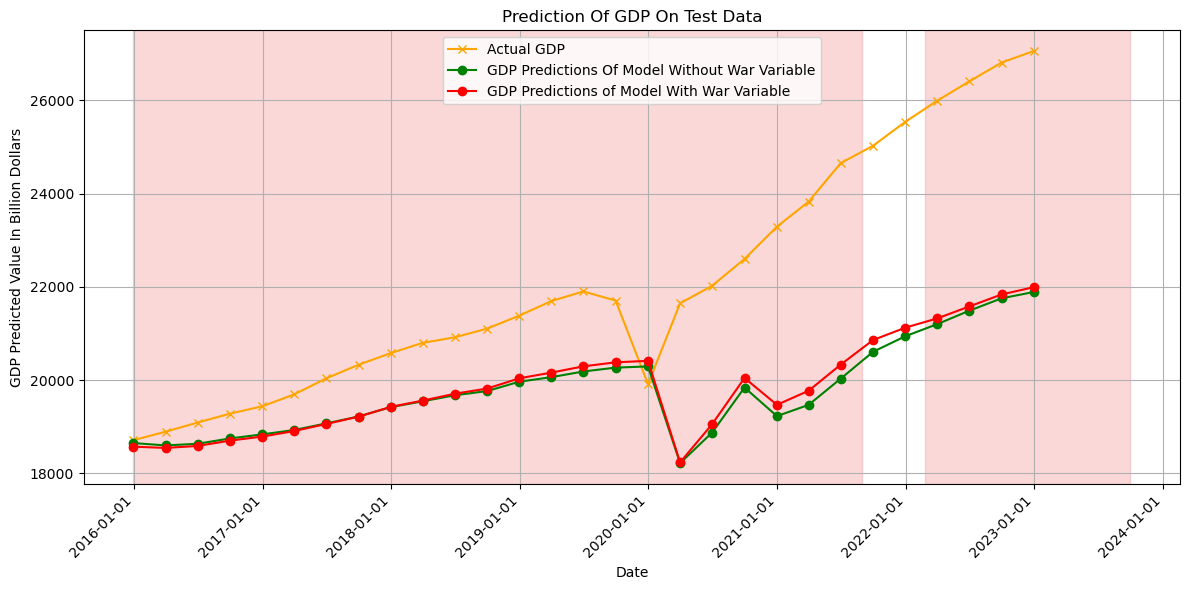

In [125]:
plot_actual_war_test(test_results_forced_no_war_df,test_results_forced_always_war_df)

### Forcing War Variable Comparative Analysis

In [113]:
num_samples = len(test_results_forced_no_war_df)
dates = pd.date_range(start='2015-12-31', periods=num_samples, freq='Q')
df_differences=test_results_forced_always_war_df['Predictions']-test_results_forced_no_war_df['Predictions']
df_comparison = pd.DataFrame({
    "Time Point": dates,
    "GDP Predictions No War": test_results_forced_no_war_df['Predictions'],
    "GDP Predictions Always War": test_results_forced_always_war_df['Predictions'],
    "Difference": df_differences
})
df_comparison.head()

,Time Point,GDP Predictions No War,GDP Predictions Always War,Difference
0,2015-12-31,18648.626953,18571.542969,-77.083984
1,2016-03-31,18598.601562,18544.507812,-54.093750
2,2016-06-30,18633.806641,18587.361328,-46.445312
3,2016-09-30,18748.328125,18701.660156,-46.667969
4,2016-12-31,18835.634766,18788.568359,-47.066406


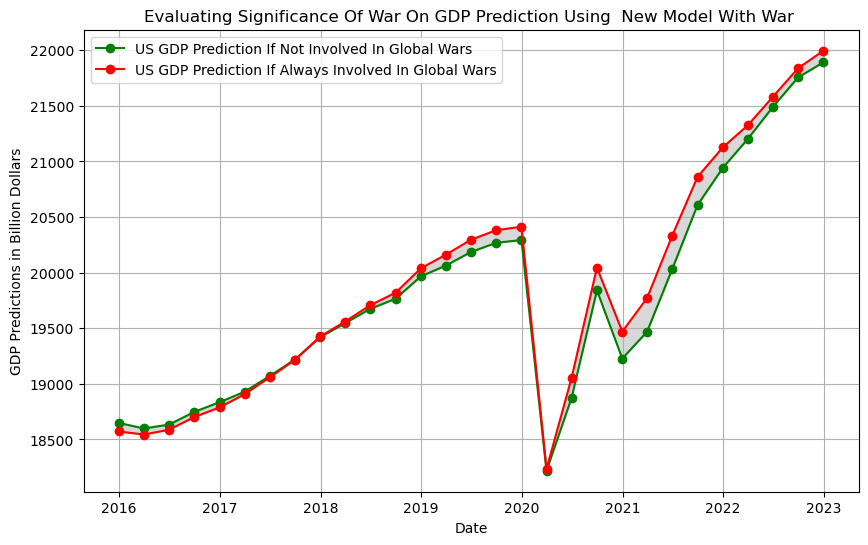

In [127]:
df_comparison_date = df_comparison.copy()
df_comparison_date['Date'] = dates
df_comparison_date = df_comparison_date.drop('Time Point', axis=1)
df_comparison_date = df_comparison_date[['Date', 'GDP Predictions No War', 'GDP Predictions Always War', 'Difference']]
plt.figure(figsize=(10, 6))
plt.plot(df_comparison_date['Date'], df_comparison_date['GDP Predictions No War'], label='US GDP Prediction If Not Involved In Global Wars', marker='o', color='green')
plt.plot(df_comparison_date['Date'], df_comparison_date['GDP Predictions Always War'], label='US GDP Prediction If Always Involved In Global Wars', marker='o', color='red')
plt.fill_between(df_comparison_date['Date'], df_comparison_date['GDP Predictions No War'], df_comparison_date['GDP Predictions Always War'], color='gray', alpha=0.3)
plt.title('Evaluating Significance Of War On GDP Prediction Using  New Model With War ')
plt.xlabel('Date')
plt.ylabel('GDP Predictions in Billion Dollars')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance for GDP prediction

In [15]:
economic_data_scaled_with_war = add_war_variable_to_df(economic_data_scaled)

param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
window=20
n_future = 1
n_past = 20 
rmse_scores = {}
column_names=list(economic_data_scaled_with_war.columns)
for feature in column_names:
    data_without_feature = economic_data_scaled_with_war.drop(columns=[feature])
    (X_train, y_train), (X_test, y_test) = train_data_split(data_without_feature, n_future, n_past)
    features = X_train.shape[2]
    num_nodes=param_grid['num_nodes']
    learning_rate=param_grid['learning_rate']
    drop_out=param_grid['drop_out']
    init_mode=param_grid['init_mode']
    activation=param_grid['activation']
    optimizer=param_grid['optimizer']
    n_batch=param_grid['batch_size']
    model_gru=define_model_gru(num_nodes, learning_rate, drop_out, activation, init_mode, optimizer, window=window, features=features)
    trained_model_feature_importance_gru = train_model(model_gru, X_train, y_train, n_batch, epochs=100, is_early_stopping=True)
    test_results_df, rmse = pred_test(trained_model_feature_importance_gru.model, X_test, y_test)
    rmse_scores[feature] = rmse
feature_importance_df=pd.DataFrame(list(rmse_scores.items()), columns=['Feature', 'RMSE'])

del test_results_df

train_size =  257
test_size =  29
train_size =  (257, 20, 12)
test_size =  (29, 20, 12)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 24)                2736      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,761
Trainable params: 2,761
Non-trainable params: 0
_________________________________________________________________
X_train (257, 20, 12)
y_train (257, 1)
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
1/1 [==============================] - 0s 141ms/step
train_size =  257
test_size =  29
train_size =  (25

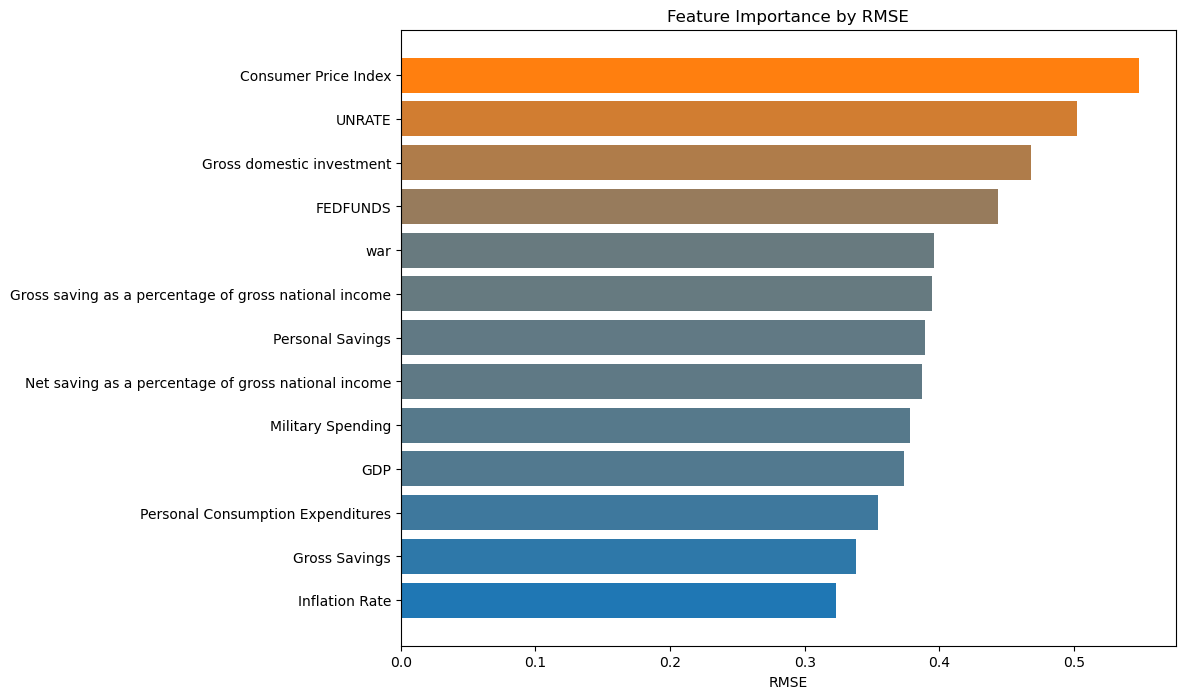

In [16]:
def interpolate_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    dark_red = np.array([0xFF, 0x7F, 0x0F]) / 255.0  
    light_green = np.array([0x1F, 0x77, 0xB4]) / 255.0
    color = light_green * (1 - normalized) + dark_red *normalized
    return color
sorted_df = feature_importance_df.sort_values(by="RMSE", ascending=True)
colors = [interpolate_color(value, sorted_df["RMSE"].min(), sorted_df["RMSE"].max()) for value in sorted_df["RMSE"]]
plt.figure(figsize=(10, 8))
plt.barh(sorted_df["Feature"], sorted_df["RMSE"], color=colors)
plt.xlabel("RMSE")
plt.title("Feature Importance by RMSE")
plt.show()


### Final Error Analysis

#### War Model

In [17]:
test_results_with_war_df.head()

,Predictions,Actuals
0,1.600685,1.620114
1,1.596937,1.645196
2,1.602877,1.672469
3,1.618722,1.698906
4,1.630770,1.720886


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_results_with_war_df['Actuals'], test_results_with_war_df['Predictions']))
test_results_with_war_df['RMSE_War'] = rmse_with_war
test_results_with_war_df.head()


,Predictions,Actuals,RMSE_War
0,1.600685,1.620114,0.390569
1,1.596937,1.645196,0.390569
2,1.602877,1.672469,0.390569
3,1.618722,1.698906,0.390569
4,1.630770,1.720886,0.390569


#### No war model

In [19]:
test_results_without_war_df.head()

,Predictions,Actuals
0,1.603251,1.620114
1,1.595936,1.645196
2,1.600206,1.672469
3,1.617336,1.698906
4,1.631170,1.720886


In [20]:

rmse = sqrt(mean_squared_error(test_results_without_war_df['Actuals'], test_results_without_war_df['Predictions']))
test_results_without_war_df['RMSE'] = rmse_without_war
test_results_without_war_df.head()

,Predictions,Actuals,RMSE
0,1.603251,1.620114,0.39589
1,1.595936,1.645196,0.39589
2,1.600206,1.672469,0.39589
3,1.617336,1.698906,0.39589
4,1.631170,1.720886,0.39589


In [21]:
concat_error_df=pd.concat([test_results_with_war_df, test_results_without_war_df], axis=1)[['RMSE_War','RMSE']]
concat_error_df.head()

,RMSE_War,RMSE
0,0.390569,0.39589
1,0.390569,0.39589
2,0.390569,0.39589
3,0.390569,0.39589
4,0.390569,0.39589


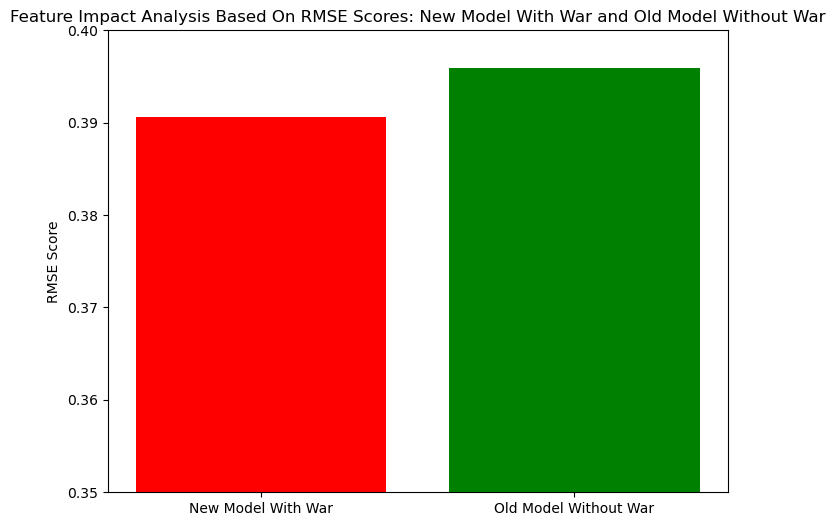

In [126]:
average_rmse_with_war = np.mean(concat_error_df['RMSE_War'])
average_rmse = np.mean(concat_error_df['RMSE'])
rmse_averages = [average_rmse_with_war, average_rmse]
labels = ['New Model With War', 'Old Model Without War']
plt.figure(figsize=(8, 6))
plt.bar(labels, rmse_averages, color=['red', 'green'])
plt.title('Feature Impact Analysis Based On RMSE Scores: New Model With War and Old Model Without War')
plt.ylabel('RMSE Score')
plt.ylim(0.35, 0.4)
plt.show()

### Failure Analysis During Model Training

In [111]:
economic_data_scaled_with_war = add_war_variable_to_df(economic_data_scaled)
param_grid = {
    'num_nodes': 24,
    'batch_size': 4,
    'activation':'tanh',
    'drop_out': 0.1,
    'init_mode': 'glorot_uniform',
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
window = 20
n_future = 1
n_past = window  

(X_train, y_train), (X_test, y_test) = train_data_split(economic_data_scaled_with_war, n_future, n_past)
train_results_df, rmse = pred_test(trained_model_gru_with_war.model, X_train, y_train)
train_results_unscaled_df = undo_scaling(train_results_df, economic_data_scaler)


train_size =  257
test_size =  29
train_size =  (257, 20, 13)
test_size =  (29, 20, 13)
9/9 [==============================] - 0s 913us/step


In [123]:
train_results_unscaled_df[(72 - 20) : (112 - 20)].head()

,Predictions,Actuals
52,756.196289,717.790
53,777.687012,730.191
54,761.417480,749.323
55,750.367676,771.857
56,735.854004,795.734


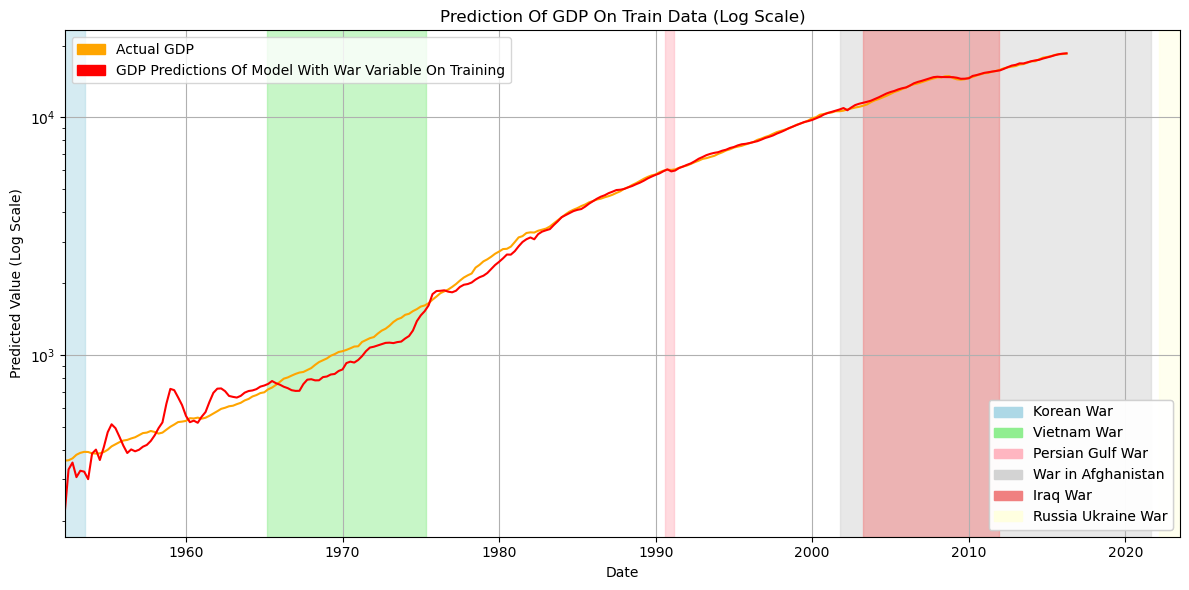

In [122]:
plot_failure_analysis(train_results_unscaled_df)